In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
from torchvision.io import read_image
# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score
import nibabel as nib
import glob
import random
import numpy as np
import os
from natsort import natsorted

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt



In [2]:


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:

#Reading an example PCT volume
LOCATION = 'HOME'

if LOCATION == 'HOME':
    ROOT_EXP = '/Users/admin/work/aifnet_replication-main'
    root_dir  = '/Users/admin/work/data/'


if LOCATION == 'LOCAL':
    ROOT_EXP = '/Users/sebastianotalora/work/postdoc/ctp/aifnet_replication/'
    root_dir  = '/Users/sebastianotalora/work/postdoc/data/ISLES/'

if LOCATION == 'INSEL':
    ROOT_EXP = '/home/sebastian/experiments/aifnet_replication/'
    root_dir  = '/media/sebastian/data/ASAP/ISLES2018_Training'

if LOCATION == 'SERVER':
    ROOT_EXP = '/home/sotalora/aifnet_replication/'
    root_dir     = '/data/images/sotalora/ISLES18/'

aif_annotations_path = ROOT_EXP + 'radiologist_annotations.csv'


aif_annotations_path = ROOT_EXP + '/radiologist_annotations_cleaned.csv'#'radiologist_annotations.csv'#'annotated_aif_vof_complete_revised.csv'
min_num_volumes_ctp = 43


In [31]:

class ISLESDataset(Dataset):
    def __init__(self, annotations_file, partition_file_path, 
                 minimum_number_volumes_ctp, img_dir, vascular_fn='AIF',
                 transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.minimum_number_volumes_ctp = minimum_number_volumes_ctp
        dataset_dir = os.path.join(img_dir, "TRAINING")
        dataset_dir_test = os.path.join(img_dir, "TESTING")
        self.filenames_4D = natsorted(glob.glob(dataset_dir + "/case_*/*4D*/*nii*") + glob.glob(dataset_dir_test + "/case_*/*4D*/*nii*"))
        self.cases_paths = {path.split('.')[-2]: path for path in self.filenames_4D}
        self.vascular_fn = vascular_fn
        partition_file = open(partition_file_path,'r')
        relevant_cases = []
        for line in partition_file:
            relevant_cases.append(line.split('.')[-2])
        partition_file.close()
        self.fold_img_paths = {key: self.cases_paths[key] for key in relevant_cases}
        self.fold_ids = [int(valid_indx) for valid_indx in list(self.fold_img_paths.keys())]
        self.all_labels = pd.read_csv(aif_annotations_path)
        self.img_labels = self.all_labels[self.all_labels['imageID'].isin(self.fold_ids)]
        #print(self.fold_img_paths)
        
    def __len__(self):
        return len(self.fold_img_paths)

    def __getitem__(self, idx):
        img_id = str(self.img_labels.iloc[idx]['imageID'])
        img_path = self.fold_img_paths[img_id]
        image = read_volume_sequence(img_path,self.minimum_number_volumes_ctp)
        AIF = image[self.img_labels.iloc[idx]['AIFx'],self.img_labels.iloc[idx]['AIFy'],self.img_labels.iloc[idx]['AIFz'],:]
        VOF = image[self.img_labels.iloc[idx]['VOFx'],self.img_labels.iloc[idx]['VOFy'],self.img_labels.iloc[idx]['VOFz'],:]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        label = AIF #By default return only the AIF
        if self.vascular_fn == 'VOF':
            label = VOF
        return image, label
def read_volume_sequence(fname,minimum_number_volumes_ctp):
        cur_nib = nib.load(fname)
        ctp_vals = cur_nib.get_fdata()
        volume_sequence = ctp_vals[:,:,:,0:minimum_number_volumes_ctp]
        return volume_sequence

In [36]:
annotations_file = aif_annotations_path
current_fold = 1
minimum_number_volumes_ctp = 43
partition_file_path = ROOT_EXP + '/partitions_cleaned/fold_'+str(current_fold)+'/train_v2.txt'
training_data = ISLESDataset(
annotations_file, partition_file_path, 
                 minimum_number_volumes_ctp, root_dir, vascular_fn='AIF',
                 transform=None, target_transform=None
)


In [37]:
sample_idx = torch.randint(10, size=(1,)).item()
img, label = training_data[sample_idx]


In [38]:
np.array(label).shape

(43,)

Text(0, 0.5, 'Normalized Density (HU)')

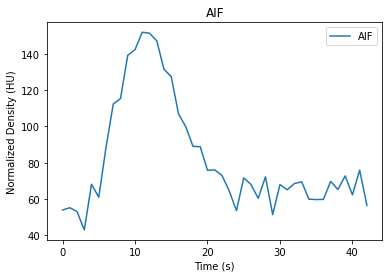

In [39]:
plt.title('AIF')        
#y = normalize_zero_one(aif)
#y_p = normalize_zero_one(vof)
#plt.plot(mu_voi)
#plt.plot(y_p)
plt.plot(label)
plt.legend([ 'AIF','VOF'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [40]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


In [41]:
train_features, train_labels = next(iter(train_dataloader))


In [42]:
train_features.shape

torch.Size([1, 256, 256, 8, 43])

In [43]:
train_labels.shape

torch.Size([1, 43])